In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import math
import cv2
from keras.models import model_from_json, load_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.metrics import AUC
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
from stn import spatial_transformer_network as transformer

In [2]:
df = pd.read_csv('fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

In [4]:
dim = int(math.sqrt(len(df.pixels[0].split(' '))))

In [5]:
emotion_count = df.emotion.value_counts()
print(emotion_count)

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64


<AxesSubplot:ylabel='emotion'>

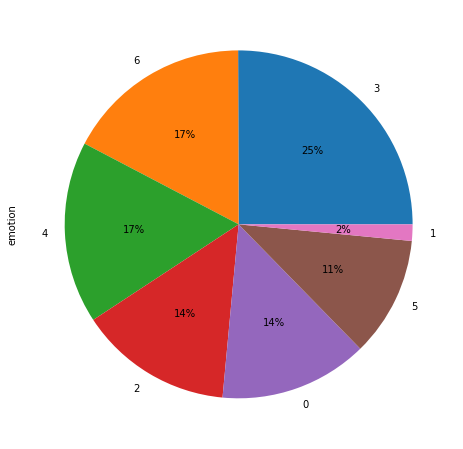

In [6]:
emotion_count.plot(kind='pie', autopct='%1.0f%%', figsize=(8, 8))

<AxesSubplot:ylabel='emotion'>

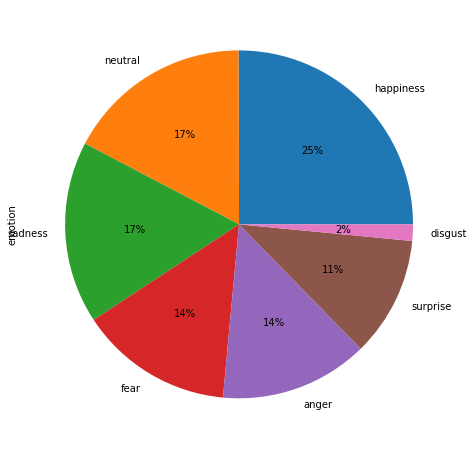

In [7]:
# emotion_label_to_text = {0:'Negative', 1:'Positive'}
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
df = df.replace({'emotion': emotion_label_to_text})
class_types = df.emotion.unique()
emotion_count = df.emotion.value_counts()
emotion_count.plot(kind='pie', autopct='%1.0f%%', figsize=(8, 8))

In [8]:
def augment_pixels(px):
    image = np.array(px.split(' ')).reshape(48, 48).astype('float32')
    image = tf.image.random_flip_left_right(image.reshape(48, 48, 1))
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, 0.2, 0.5)
    image = tf.clip_by_value(image, 0, 255)
    augmented_img = image.numpy().reshape(48, 48)
    img_concat = ' '.join(augmented_img.reshape(48*48).astype('int').astype(str))
    return img_concat

valcounts = df.emotion.value_counts()
valcounts_diff = valcounts[valcounts.idxmax()] - valcounts
for emotion_idx, aug_count in valcounts_diff.iteritems():
    sampled = df.query("emotion==@emotion_idx").sample(aug_count, replace=True)
    sampled['pixels'] = sampled.pixels.apply(augment_pixels)
    df = pd.concat([df, sampled])

In [9]:
emotion_count = df.emotion.value_counts()
print(emotion_count)

anger        8989
fear         8989
sadness      8989
neutral      8989
happiness    8989
surprise     8989
disgust      8989
Name: emotion, dtype: int64


<AxesSubplot:ylabel='emotion'>

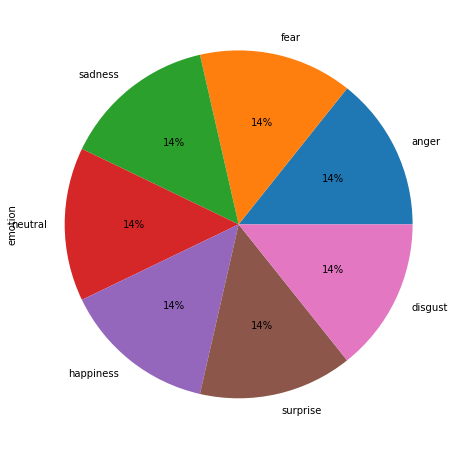

In [10]:
emotion_count.plot(kind='pie', autopct='%1.0f%%', figsize=(8, 8))

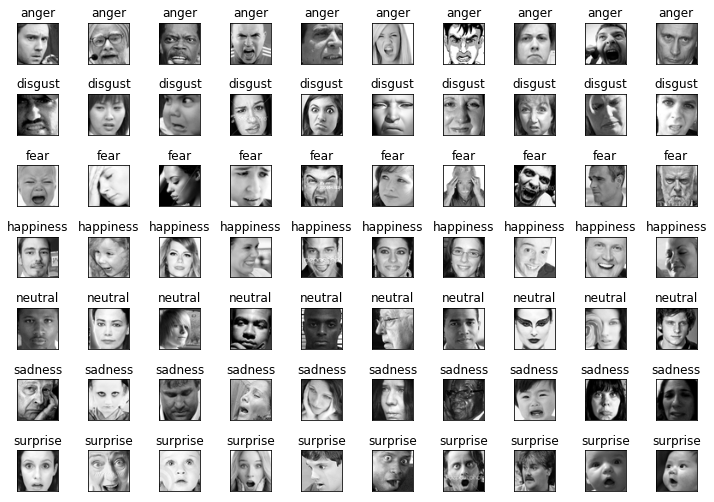

In [11]:
plt.figure(figsize=(10, 10))
count = 0
for label in sorted(df.emotion.unique()):
    for i in range(10):
        px = df[df.emotion==label].pixels.iloc[count]
        px = np.array(px.split(' ')).reshape(dim, dim).astype('float32')
        count += 1
        ax = plt.subplot(10, 10, count)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label)
        plt.tight_layout()

In [12]:
img_df = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(dim, dim, 1).astype('float32'))
img_df = np.stack(img_df, axis=0)

In [13]:
img_df.shape

(62923, 48, 48, 1)

In [14]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(62923, 7)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(img_df, img_labels, shuffle=True, stratify=img_labels, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((47192, 48, 48, 1), (15731, 48, 48, 1), (47192, 7), (15731, 7))

In [16]:
# img_width = X_train.shape[1]
# img_height = X_train.shape[2]
# img_depth = X_train.shape[3]
# num_classes = y_train.shape[1]

In [17]:
X_train = X_train / 255.
X_test = X_test / 255.

# X_train = X_train.reshape(len(X_train), 48 * 48 * 1)
# s = SMOTE(random_state=42)
# X_smote, y_smote = s.fit_resample(X_train, y_train)
# X_smote = X_smote.reshape(-1, 48, 48, 1)
# X_smote.shape

# class_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
# class_weights = dict(enumerate(class_weights))

In [18]:
class STN(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(STN, self).__init__(**kwargs)
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv1 = tf.keras.layers.Conv2D(32, [5, 5], activation='relu')
        self.pool2 = tf.keras.layers.MaxPool2D()
        self.conv2 = tf.keras.layers.Conv2D(64, [5, 5], activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(12, activation='relu')
        self.fc2 = tf.keras.layers.Dense(6, activation=None, bias_initializer=tf.keras.initializers.constant([1.0, 0.0, 0.0, 0.0, 1.0, 0.0]), kernel_initializer='zeros')

    def build(self, input_shape):
        print("Building Localization Network with input shape:", input_shape)

    def compute_output_shape(self, input_shape):
        return [None, 6]

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        theta = self.fc2(x)
        out = transformer(inputs, theta)
        return out

In [19]:
def get_stn_model(input_shape):
    
    image = tf.keras.layers.Input(shape=input_shape)
    x = STN()(image)
   
    x = tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(5,5),
        input_shape=input_shape,
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(5,5),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dropout(0.4)(x)


    x = tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Flatten()(x)
        
    x = tf.keras.layers.Dense(
        256,
        activation='relu',
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        bias_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Dense(
        512,
        activation='relu',
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        bias_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Dense(
        7,
        activation='softmax',
    )(x)
    
    return tf.keras.models.Model(inputs=image, outputs=x)

In [20]:
# es_callback = tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True, min_delta=0.0001)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, min_lr=1e-7, verbose=1)
checkpoint = ModelCheckpoint(filepath='saved_models/best_weight_FER.h5', mode='max', monitor='val_accuracy', verbose=1, save_best_only=True)
# datagen = ImageDataGenerator(rotation_range=10, brightness_range=[0.6,1], horizontal_flip=True, featurewise_center=True, featurewise_std_normalization=True)

# datagen.fit(X_train)

In [21]:
# X = np.concatenate((X_train, X_test), axis=0)
# y = np.concatenate((y_train, y_test), axis=0)
# acc_per_fold = []
# loss_per_fold = []

# kfold = KFold(n_splits=5)
# fold_count = 1
# for train, test in kfold.split(X, y):
stn_model = get_stn_model((X_train.shape[1], X_train.shape[2], X_train.shape[3]))
batch_size = 48
stn_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), 
                  metrics=['accuracy', AUC(multi_label=True, num_labels=7)])
# print(f'\nFold {fold_count}/5')
stn_model_result = stn_model.fit(X_train, y_train, validation_split=0.2, batch_size=batch_size, steps_per_epoch=len(X_train)/batch_size, 
              epochs=60, callbacks=[checkpoint, reduce_lr])
    
# scores = stn_model.evaluate(X[test], y[test])
# print(f'Fold {fold_count}/5 - {stn_model.metrics_names[0]}: {scores[0]} - {stn_model.metrics_names[1]}: {round(scores[1]*100, 2)}%\n')
# loss_per_fold.append(scores[0])
# acc_per_fold.append(round(scores[1]*100, 2))

# fold_count = fold_count + 1
    
# print(f'val_loss_avg: {np.mean(loss_per_fold)}')
# print(f'val_acc_avg: {round(np.mean(acc_per_fold), 2)}%')


Building Localization Network with input shape: (None, 48, 48, 1)
Epoch 1/60
983/983 [============================>.] - ETA: 0s - loss: 5.5926 - accuracy: 0.3157 - auc: 0.6840
Epoch 1: val_accuracy improved from -inf to 0.43839, saving model to saved_models\best_weight_FER.h5
983/983 [==============================] - 43s 37ms/step - loss: 5.5894 - accuracy: 0.3157 - auc: 0.6841 - val_loss: 2.2241 - val_accuracy: 0.4384 - val_auc: 0.7727 - lr: 0.0010
Epoch 2/60
984/983 [==============================] - ETA: 0s - loss: 2.1383 - accuracy: 0.4440 - auc: 0.7903
Epoch 2: val_accuracy improved from 0.43839 to 0.44888, saving model to saved_models\best_weight_FER.h5
983/983 [==============================] - 34s 35ms/step - loss: 2.1383 - accuracy: 0.4440 - auc: 0.7903 - val_loss: 2.0765 - val_accuracy: 0.4489 - val_auc: 0.8078 - lr: 0.0010
Epoch 3/60
983/983 [============================>.] - ETA: 0s - loss: 2.0315 - accuracy: 0.4968 - auc: 0.8254
Epoch 3: val_accuracy improved from 0.44888

Epoch 23/60
983/983 [============================>.] - ETA: 0s - loss: 1.3605 - accuracy: 0.7253 - auc: 0.9384
Epoch 23: val_accuracy improved from 0.67539 to 0.68535, saving model to saved_models\best_weight_FER.h5
983/983 [==============================] - 33s 33ms/step - loss: 1.3603 - accuracy: 0.7253 - auc: 0.9384 - val_loss: 1.4548 - val_accuracy: 0.6853 - val_auc: 0.9240 - lr: 0.0010
Epoch 24/60
983/983 [============================>.] - ETA: 0s - loss: 1.3349 - accuracy: 0.7226 - auc: 0.9392
Epoch 24: val_accuracy improved from 0.68535 to 0.68598, saving model to saved_models\best_weight_FER.h5
983/983 [==============================] - 33s 34ms/step - loss: 1.3352 - accuracy: 0.7225 - auc: 0.9392 - val_loss: 1.4053 - val_accuracy: 0.6860 - val_auc: 0.9257 - lr: 0.0010
Epoch 25/60
983/983 [============================>.] - ETA: 0s - loss: 1.3038 - accuracy: 0.7348 - auc: 0.9425
Epoch 25: val_accuracy did not improve from 0.68598
983/983 [==============================] - 33s 34

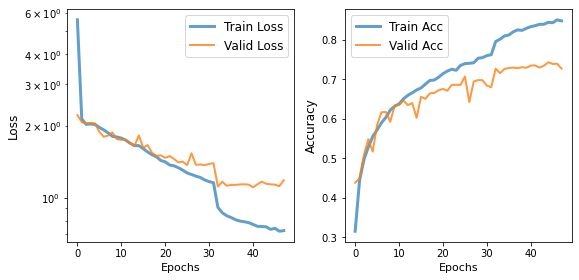

In [22]:
loss = stn_model_result.history['loss']
val_loss = stn_model_result.history['val_loss']

acc = stn_model_result.history['accuracy'] 
val_acc = stn_model_result.history['val_accuracy']

# top5_acc = stn_model.history['top5 acc']
# val_top5_acc = stn_model.history['val_top5 acc']
epochs = range(len(loss))

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.yscale('log')
plt.plot(epochs, loss, linewidth=3, alpha=0.7, label='Train Loss')
plt.plot(epochs, val_loss, linewidth=2, alpha=0.8, label='Valid Loss')
# plt.ylim(0.3, 100)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 3, 2)
plt.plot(epochs, acc, linewidth=3, alpha=0.7, label='Train Acc')
plt.plot(epochs, val_acc, linewidth=2, alpha=0.8, label='Valid Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
# plt.subplot(1, 3, 3)
# plt.plot(epochs, top5_acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Top 5 Acc')
# plt.plot(epochs, val_top5_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Top5 Acc') 
# plt.xlabel('Epochs', fontsize=11)
# plt.ylabel('Top5 Accuracy', fontsize=12)
# plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig('/content/gdrive/My Drive/Colab Notebooks/resnet/train_acc.png', dpi=250)
plt.show()

Building Localization Network with input shape: (None, 48, 48, 1)
Classification Report:

              precision    recall  f1-score   support

       anger       0.56      0.72      0.63      2248
        fear       0.97      0.99      0.98      2247
     sadness       0.71      0.44      0.54      2247
     neutral       0.85      0.84      0.84      2248
   happiness       0.67      0.63      0.65      2247
    surprise       0.56      0.62      0.59      2247
     disgust       0.84      0.89      0.86      2247

    accuracy                           0.73     15731
   macro avg       0.74      0.73      0.73     15731
weighted avg       0.74      0.73      0.73     15731



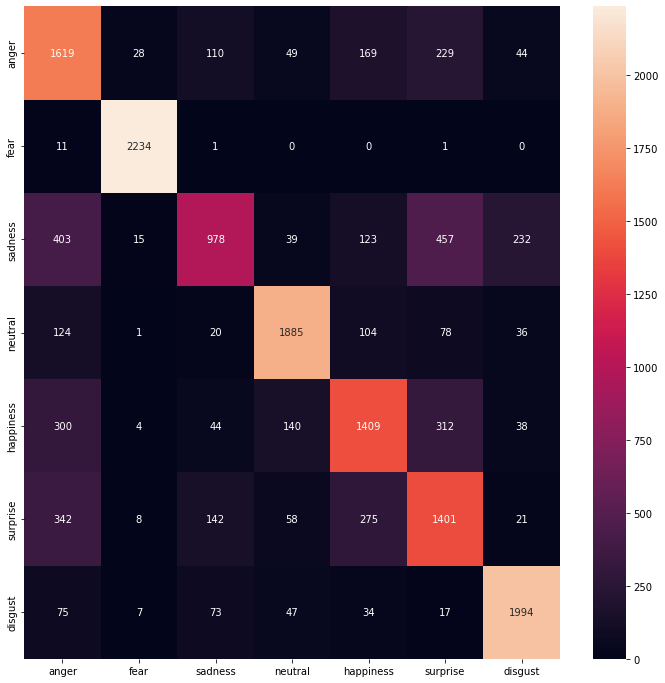

In [23]:
def conf_matrix(predictions): 

    rounded_labels = np.argmax(y_test, axis=1)
    cm = confusion_matrix(rounded_labels, np.argmax(np.round(predictions), axis=1))
    print("Classification Report:\n")
    cr = classification_report(rounded_labels, np.argmax(np.round(predictions), axis=1), 
                                target_names=[class_types[i] for i in range(len(class_types))])
    print(cr)
    plt.figure(figsize=(12, 12))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels=[class_types[i] for i in range(len(class_types))], 
                yticklabels=[class_types[i] for i in range(len(class_types))], fmt="d")
    fig = sns_hmp.get_figure()

saved_stn_model = load_model('saved_models/best_weight_FER.h5', custom_objects={'STN': STN}, compile=False)
pred_class = saved_stn_model.predict(X_test)
conf_matrix(pred_class)

In [24]:
model_json = stn_model.to_json()
with open("saved_models/fer_model.json", "w") as json_file:
    json_file.write(model_json)